# Add Starting Pitching to Model
- In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
- Now we will add these features in to see how much improvement we get to our model.

NOTE: have modified the previous notebook (added "Strt_" to feature names)


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [12]:
df=pd.read_csv('df_bp5.csv')

/tmp/ipykernel_89789/700438063.py:1: DtypeWarning: Columns (13,14,15,19,85,87,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('df_bp5.csv')


In [13]:
df

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result,Strt_GS_h,Strt_GS_v,Strt_IP_h,Strt_IP_v,Strt_H_h,Strt_H_v,Strt_BFP_h,Strt_BFP_v,Strt_HR_h,Strt_HR_v,Strt_R_h,Strt_R_v,Strt_ER_h,Strt_ER_v,Strt_BB_h,Strt_BB_v,Strt_IB_h,Strt_IB_v,Strt_SO_h,Strt_SO_v,Strt_SH_h,Strt_SH_v,Strt_SF_h,Strt_SF_v,Strt_WP_h,Strt_WP_v,Strt_HBP_h,Strt_HBP_v,Strt_BK_h,Strt_BK_v,Strt_2B_h,Strt_2B_v,Strt_3B_h,Strt_3B_v,Strt_IP_real_h,Strt_IP_real_v,Strt_rollsum_IP_real_10_h,Strt_rollsum_IP_real_10_v,Strt_rollsum_H_10_h,Strt_rollsum_H_10_v,Strt_rollsum_BFP_10_h,Strt_rollsum_BFP_10_v,Strt_rollsum_HR_10_h,Strt_rollsum_HR_10_v,Strt_rollsum_R_10_h,Strt_rollsum_R_10_v,Strt_rollsum_ER_10_h,Strt_rollsum_ER_10_v,Strt_rollsum_BB_10_h,Strt_rollsum_BB_10_v,Strt_rollsum_IB_10_h,Strt_rollsum_IB_10_v,Strt_rollsum_SO_10_h,Strt_rollsum_SO_10_v,Strt_rollsum_SH_10_h,Strt_rollsum_SH_10_v,Strt_rollsum_SF_10_h,Strt_rollsum_SF_10_v,Strt_rollsum_WP_10_h,Strt_rollsum_WP_10_v,Strt_rollsum_HBP_10_h,Strt_rollsum_HBP_10_v,Strt_rollsum_BK_10_h,Strt_rollsum_BK_10_v,Strt_rollsum_2B_10_h,Strt_rollsum_2B_10_v,Strt_rollsum_3B_10_h,Strt_rollsum_3B_10_v,Strt_rollsum_IP_real_35_h,Strt_rollsum_IP_real_35_v,Strt_rollsum_H_35_h,Strt_rollsum_H_35_v,Strt_rollsum_BFP_35_h,Strt_rollsum_BFP_35_v,Strt_rollsum_HR_35_h,Strt_rollsum_HR_35_v,Strt_rollsum_R_35_h,Strt_rollsum_R_35_v,Strt_rollsum_ER_35_h,Strt_rollsum_ER_35_v,Strt_rollsum_BB_35_h,Strt_rollsum_BB_35_v,Strt_rollsum_IB_35_h,Strt_rollsum_IB_35_v,Strt_rollsum_SO_35_h,Strt_rollsum_SO_35_v,Strt_rollsum_SH_35_h,Strt_rollsum_SH_35_v,Strt_rollsum_SF_35_h,Strt_rollsum_SF_35_v,Strt_rollsum_WP_35_h,Strt_rollsum_WP_35_v,Strt_rollsum_HBP_35_h,Strt_rollsum_HBP_35_v,Strt_rollsum_BK_35_h,Strt_rollsum_BK_35_v,Strt_rollsum_2B_35_h,Strt_rollsum_2B_35_v,Strt_rollsum_3B_35_h,Strt_rollsum_3B_35_v,Strt_rollsum_IP_real_75_h,Strt_rollsum_IP_real_75_v,Strt_rollsum_H_75_h,Strt_rollsum_H_75_v,Strt_rollsum_BFP_75_h,Strt_rollsum_BFP_75_v,Strt_rollsum_HR_75_h,Strt_rollsum_HR_75_v,Strt_rol

In [14]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1980) & (df.season<=2018)]
df_valid = df[(df.season>=2019) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [15]:
hv_mean = df_train.home_victory.mean()

In [16]:
hv_mean

0.5386745796241346

In [17]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v', 
]
target = 'home_victory'

In [18]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [19]:
X_train.shape, X_valid.shape, X_test.shape

((85935, 8), (3327, 8), (4852, 8))

In [20]:
# Create model

lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])


[LightGBM] [Info] Number of positive: 46291, number of negative: 39644
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 85935, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538675 -> initscore=0.155008
[LightGBM] [Info] Start training from score 0.155008
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.688975
[20]	valid_0's binary_logloss: 0.687776
[30]	valid_0's binary_logloss: 0.686846
[40]	valid_0's binary_logloss: 0.686007
[50]	valid_0's binary_logloss: 0.685107
[60]	valid_0's binary_logloss: 0.684282
[70]	valid_0's binary_logloss: 0.683615
[80]	valid_0's binary_logloss: 0.682863
[90]	valid_0's binary_logloss: 0.682278
[100]	valid_0's binary_logloss: 0.681736
[110]	valid_0's binary_logloss: 0.681245
[12

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [21]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [22]:
# previous model gave 0.6830
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6749099360040226, 0.6904929522108192)

In [23]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6675629431340582

In [24]:
np.round([.6904 - .6675, .6904-.6830, .6904-.6747], decimals=4)

array([0.0229, 0.0074, 0.0157])

In [25]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

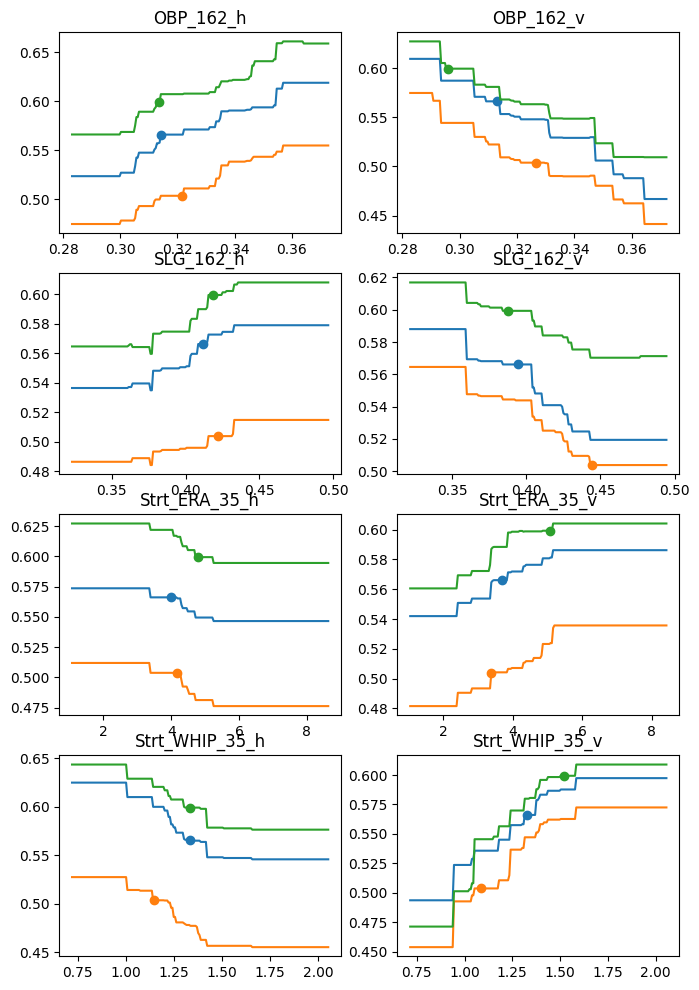

In [27]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=2)

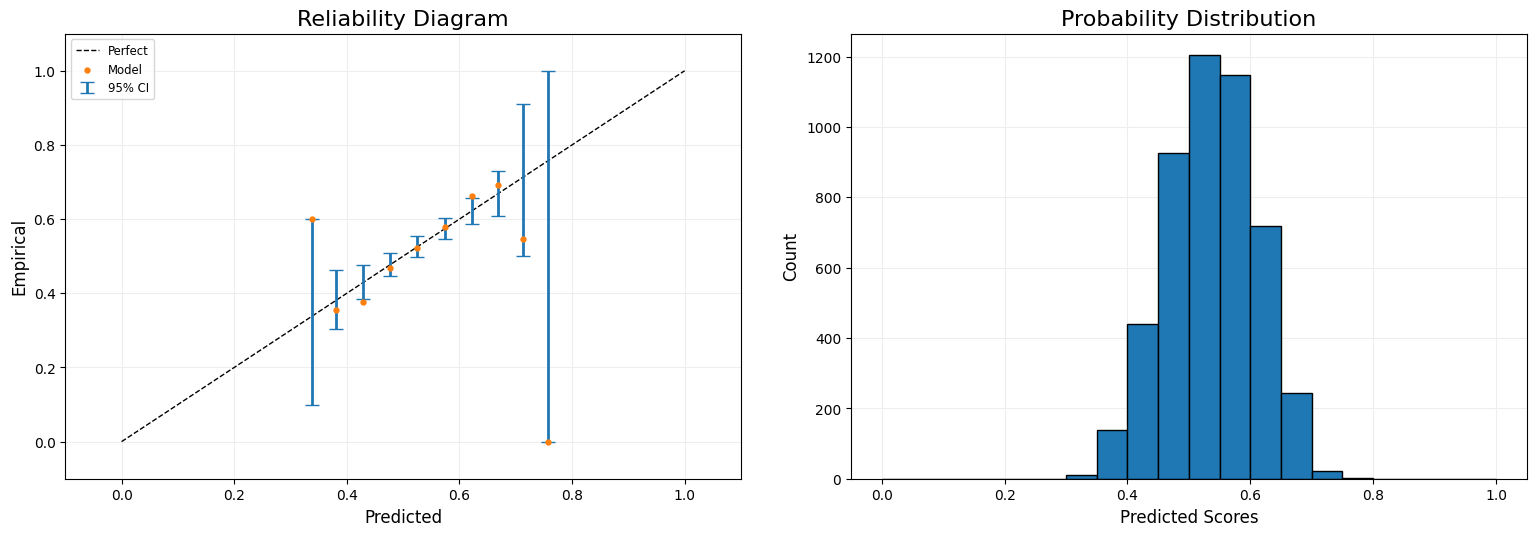

In [28]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [29]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [30]:
# This shows for each game, how the different features affected 
sv_lgbm.head(5).round(3)

,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,Strt_ERA_35_h,Strt_ERA_35_v,Strt_WHIP_35_h,Strt_WHIP_35_v,Intercept
0,-0.077,0.068,0.056,0.035,0.056,0.010,0.139,0.075,0.157
1,-0.080,0.053,0.046,0.033,0.031,-0.072,0.099,-0.206,0.157
2,-0.024,0.010,0.070,-0.101,-0.066,-0.090,0.046,-0.203,0.157
3,-0.154,0.014,-0.026,-0.039,0.029,-0.077,0.029,-0.183,0.157
4,-0.040,0.008,0.026,-0.098,0.025,-0.024,0.041,-0.452,0.157


In [31]:
df_test.pitcher_start_name_v.iloc[4]

'Kenta Maeda'

In [32]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept         0.156961
Strt_WHIP_35_v    0.089547
Strt_WHIP_35_h    0.082787
OBP_162_v         0.071504
OBP_162_h         0.069442
Strt_ERA_35_h     0.045540
SLG_162_h         0.042351
SLG_162_v         0.040248
Strt_ERA_35_v     0.038490
dtype: float64

# Add More Features

- Adding more features and creating new model

In [33]:
# Add in SO% and "Modified Slugging Against"
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
]
target = 'home_victory'


In [34]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [35]:
X_train.shape, X_valid.shape, X_test.shape, 

((85935, 14), (3327, 14), (4852, 14))

In [36]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

[LightGBM] [Info] Number of positive: 46291, number of negative: 39644
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 85935, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538675 -> initscore=0.155008
[LightGBM] [Info] Start training from score 0.155008
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.688889
[20]	valid_0's binary_logloss: 0.687737
[30]	valid_0's binary_logloss: 0.68684
[40]	valid_0's binary_logloss: 0.685746
[50]	valid_0's binary_logloss: 0.684705
[60]	valid_0's binary_logloss: 0.68378
[70]	valid_0's binary_logloss: 0.682813
[80]	valid_0's binary_logloss: 0.682067
[90]	valid_0's binary_logloss: 0.68143
[100]	valid_0's binary_logloss: 0.680878
[110]	valid_0's binary_logloss: 0.680467
[120]

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [37]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [38]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6747050237554766, 0.6904929522108192)

In [39]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

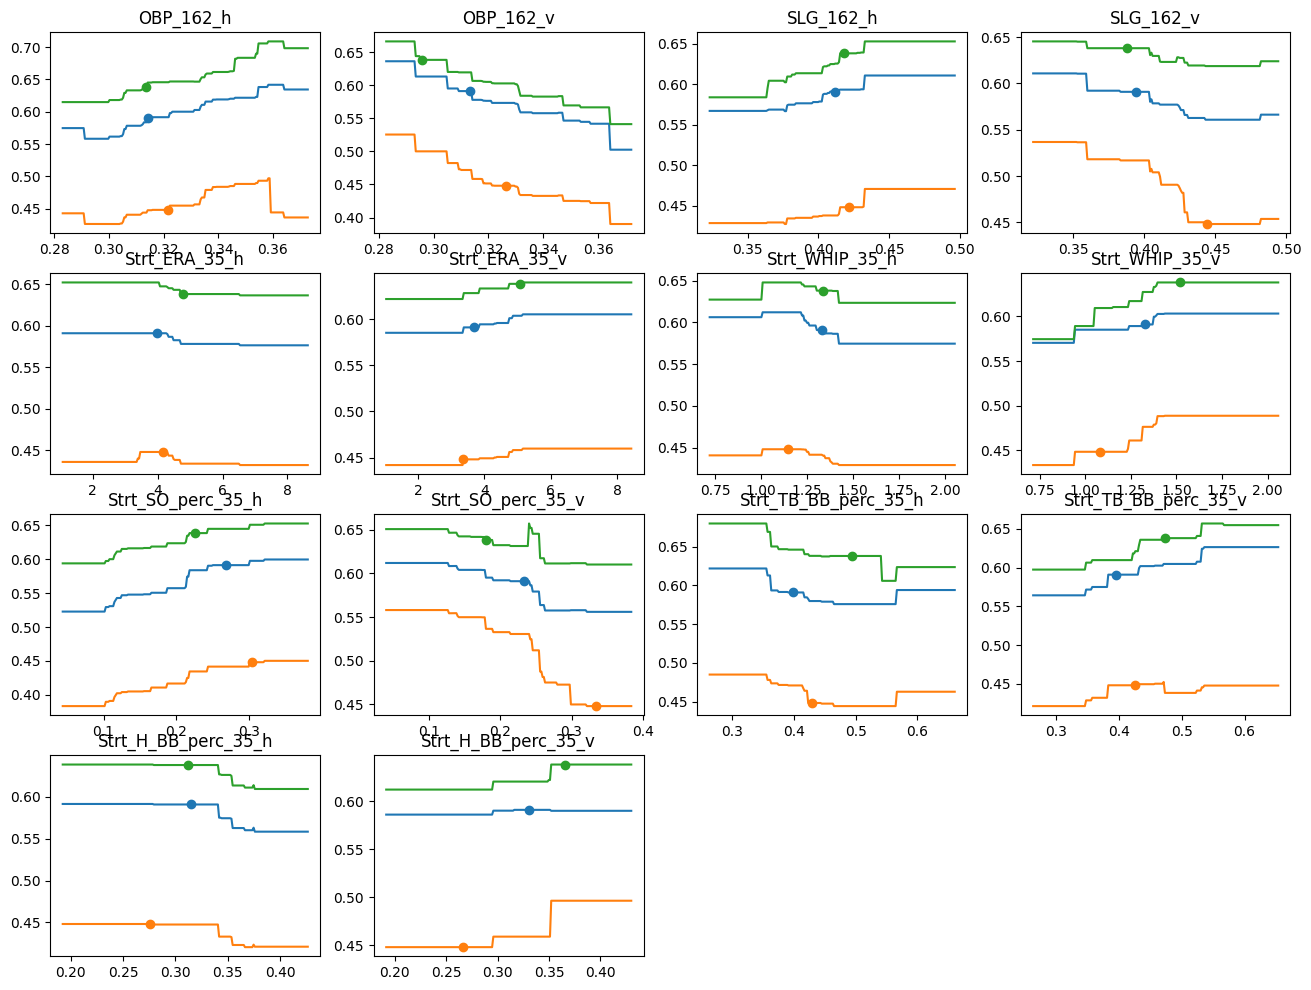

In [41]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=4)

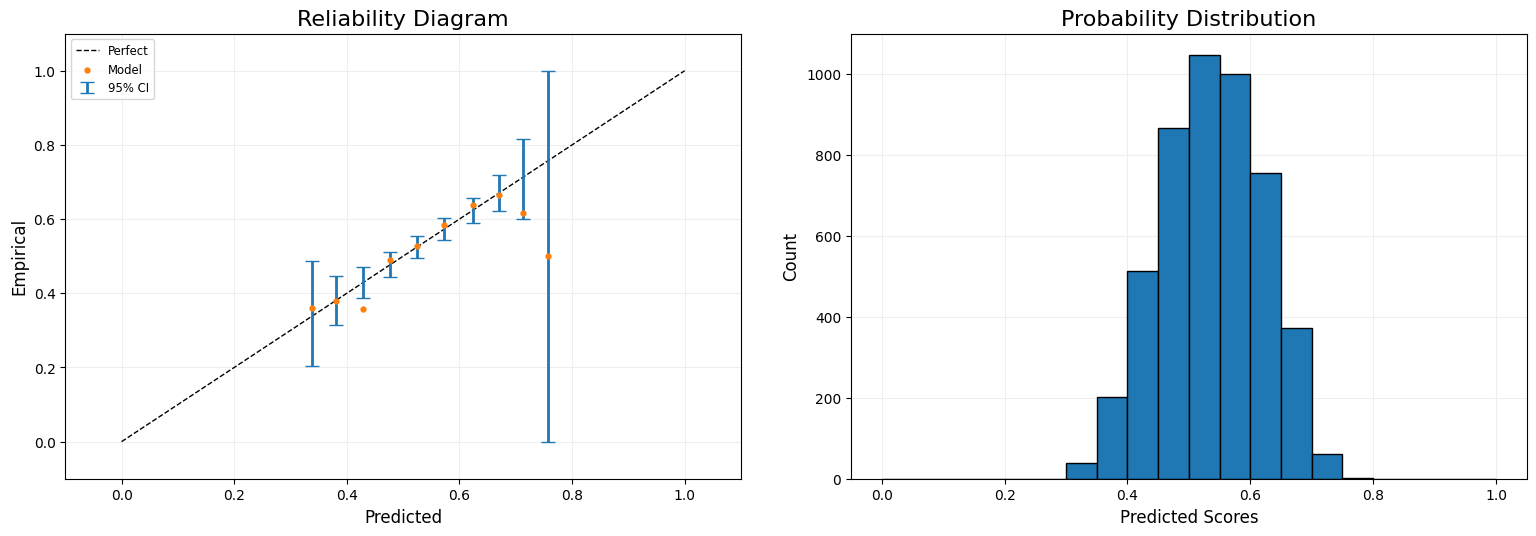

In [42]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [43]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.157262
Strt_SO_perc_35_v       0.092433
Strt_SO_perc_35_h       0.083802
OBP_162_v               0.077014
OBP_162_h               0.061073
Strt_WHIP_35_v          0.049881
SLG_162_h               0.046691
Strt_WHIP_35_h          0.045366
SLG_162_v               0.038929
Strt_TB_BB_perc_35_h    0.035676
Strt_H_BB_perc_35_v     0.024083
Strt_TB_BB_perc_35_v    0.022368
Strt_H_BB_perc_35_h     0.021697
Strt_ERA_35_v           0.021293
Strt_ERA_35_h           0.019365
dtype: float64

# Model 3

- adding even more features

In [44]:
## Let's add in the 10 game lookback features
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_ERA_10_h','Strt_ERA_10_v',
            'Strt_WHIP_10_h','Strt_WHIP_10_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Strt_TB_BB_perc_10_h', 'Strt_TB_BB_perc_10_v',
]
target = 'home_victory'


X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [45]:
X_train.shape, X_valid.shape, X_test.shape, 

((85935, 20), (3327, 20), (4852, 20))

In [46]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

[LightGBM] [Info] Number of positive: 46291, number of negative: 39644
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 85935, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538675 -> initscore=0.155008
[LightGBM] [Info] Start training from score 0.155008
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.688889
[20]	valid_0's binary_logloss: 0.687748
[30]	valid_0's binary_logloss: 0.686831
[40]	valid_0's binary_logloss: 0.68581
[50]	valid_0's binary_logloss: 0.684755
[60]	valid_0's binary_logloss: 0.68377
[70]	valid_0's binary_logloss: 0.682987
[80]	valid_0's binary_logloss: 0.682371
[90]	valid_0's binary_logloss: 0.681706
[100]	valid_0's binary_logloss: 0.681007
[110]	valid_0's binary_logloss: 0.680533
[120

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [47]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6746996260298721, 0.6904929522108192)

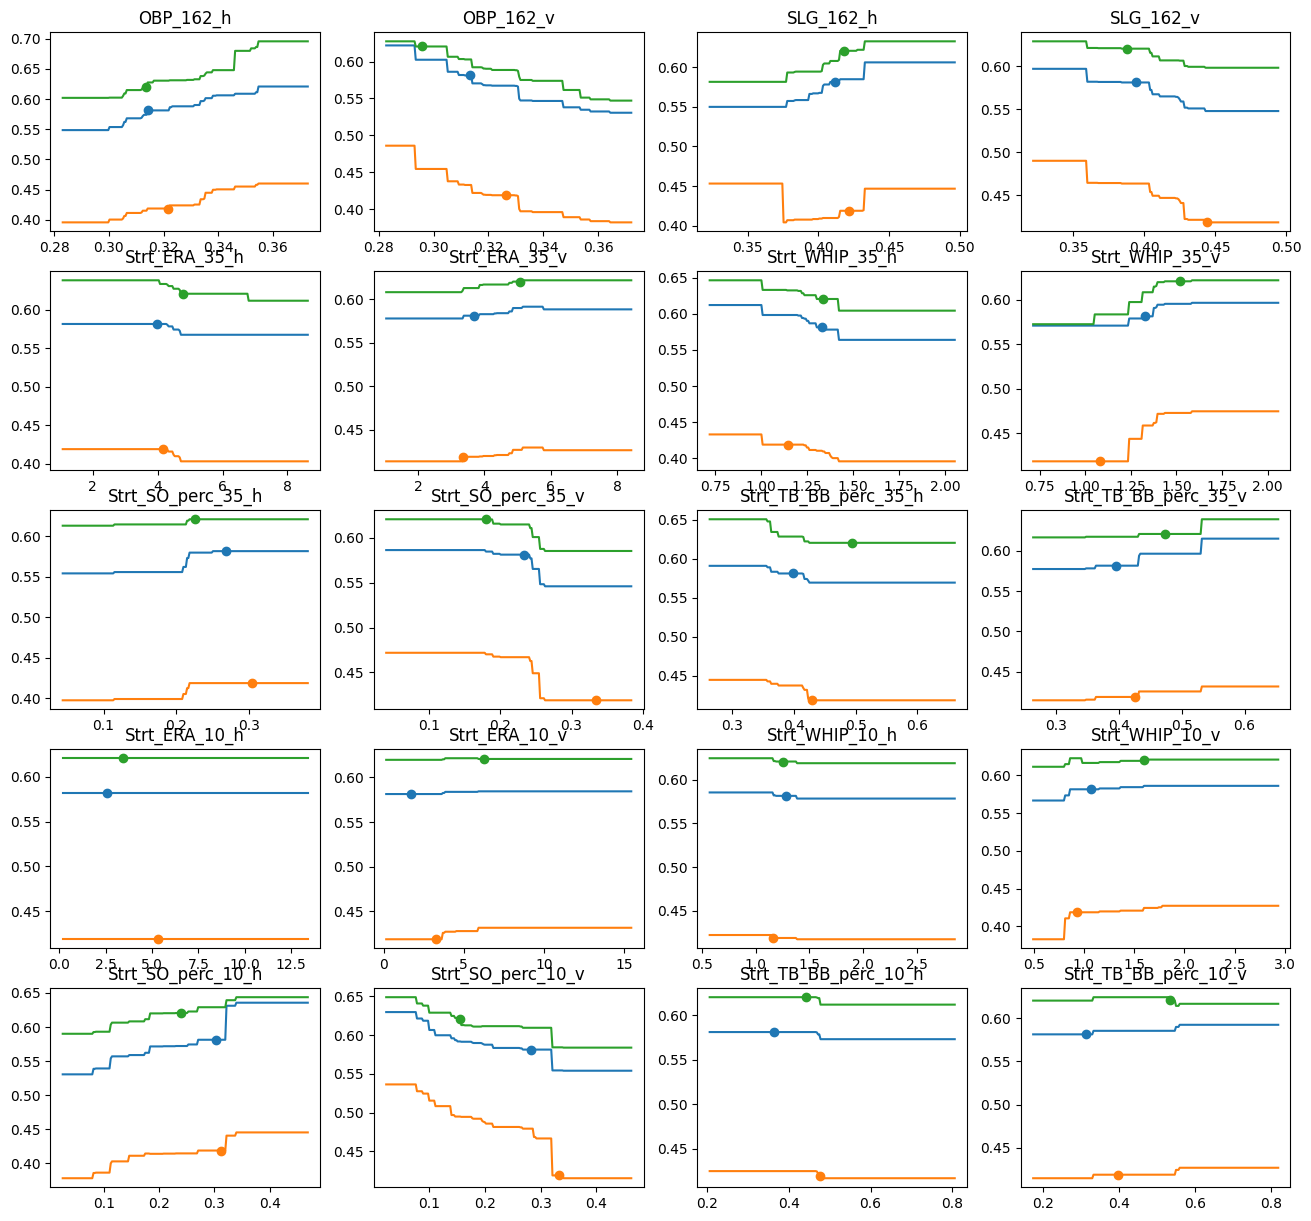

In [48]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=4)

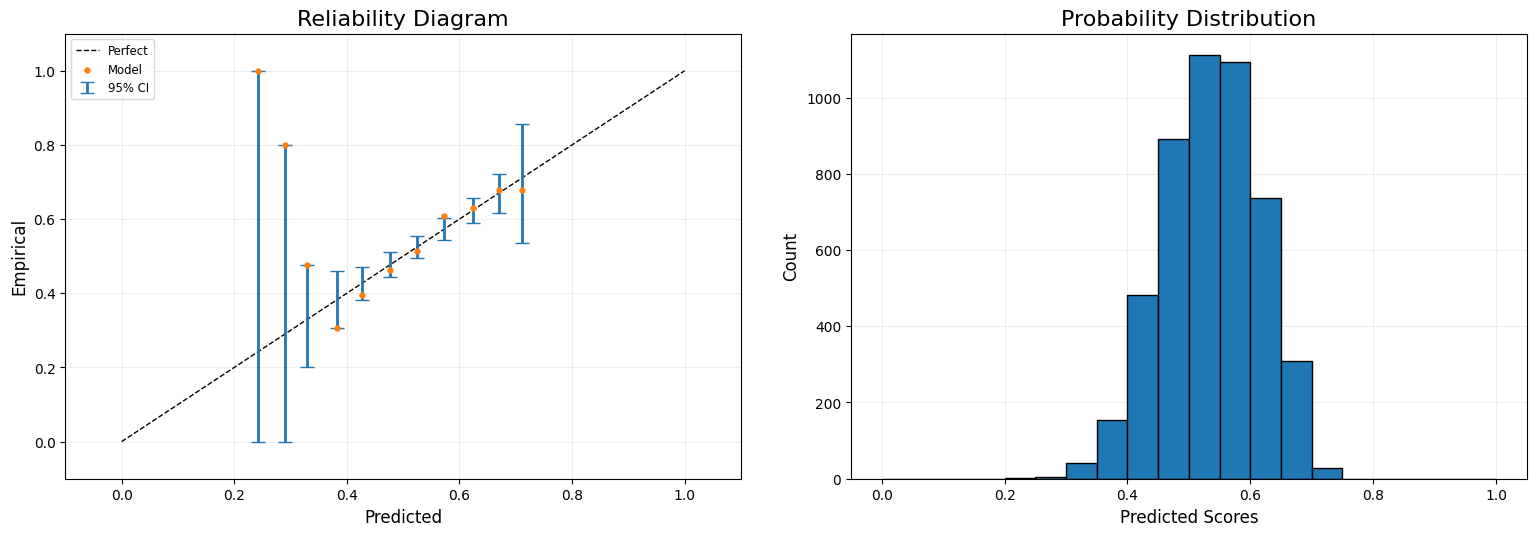

In [49]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [50]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.157145
OBP_162_v               0.068451
OBP_162_h               0.061361
Strt_WHIP_35_v          0.058638
Strt_SO_perc_10_v       0.054669
Strt_SO_perc_10_h       0.053541
Strt_WHIP_35_h          0.046333
SLG_162_h               0.044383
Strt_SO_perc_35_v       0.041581
SLG_162_v               0.034778
Strt_SO_perc_35_h       0.033795
Strt_TB_BB_perc_35_h    0.028330
Strt_ERA_35_h           0.023897
Strt_TB_BB_perc_35_v    0.016486
Strt_ERA_35_v           0.016268
Strt_TB_BB_perc_10_h    0.014271
Strt_ERA_10_v           0.012057
Strt_WHIP_10_h          0.010702
Strt_WHIP_10_v          0.007112
Strt_TB_BB_perc_10_v    0.004399
Strt_ERA_10_h           0.000146
dtype: float64

# Model 4

- Additional modeling

In [51]:
# Choose the best window size for each metric, drop ERA
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            
]
target = 'home_victory'


X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


X_train.shape, X_valid.shape, X_test.shape, 

((85935, 10), (3327, 10), (4852, 10))

In [52]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

[LightGBM] [Info] Number of positive: 46291, number of negative: 39644
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 85935, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538675 -> initscore=0.155008
[LightGBM] [Info] Start training from score 0.155008
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.688867
[20]	valid_0's binary_logloss: 0.687722
[30]	valid_0's binary_logloss: 0.686828
[40]	valid_0's binary_logloss: 0.686027
[50]	valid_0's binary_logloss: 0.685208
[60]	valid_0's binary_logloss: 0.684286
[70]	valid_0's binary_logloss: 0.683558
[80]	valid_0's binary_logloss: 0.682855
[90]	valid_0's binary_logloss: 0.682161
[100]	valid_0's bina

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [53]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]
# now about 4 bps worse than previous model..
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6749548319167735, 0.6904929522108192)

In [54]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6675629431340582

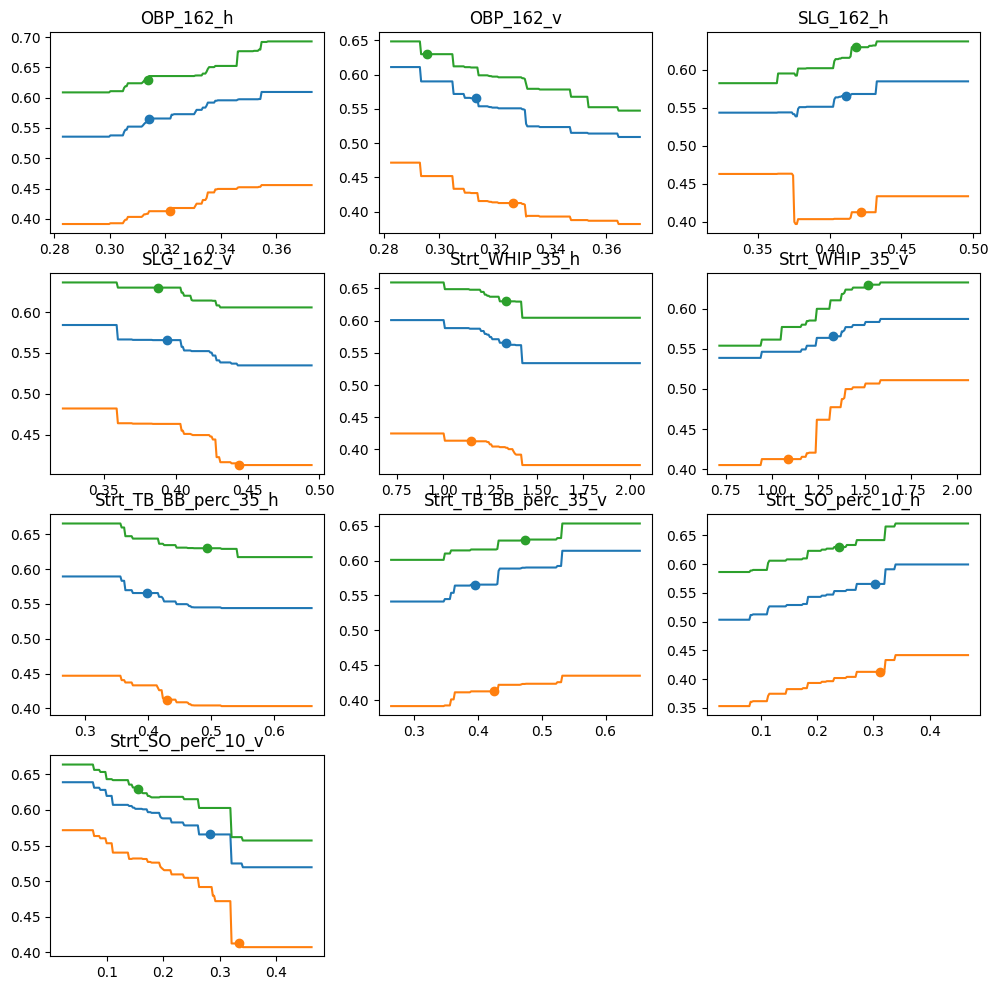

In [55]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

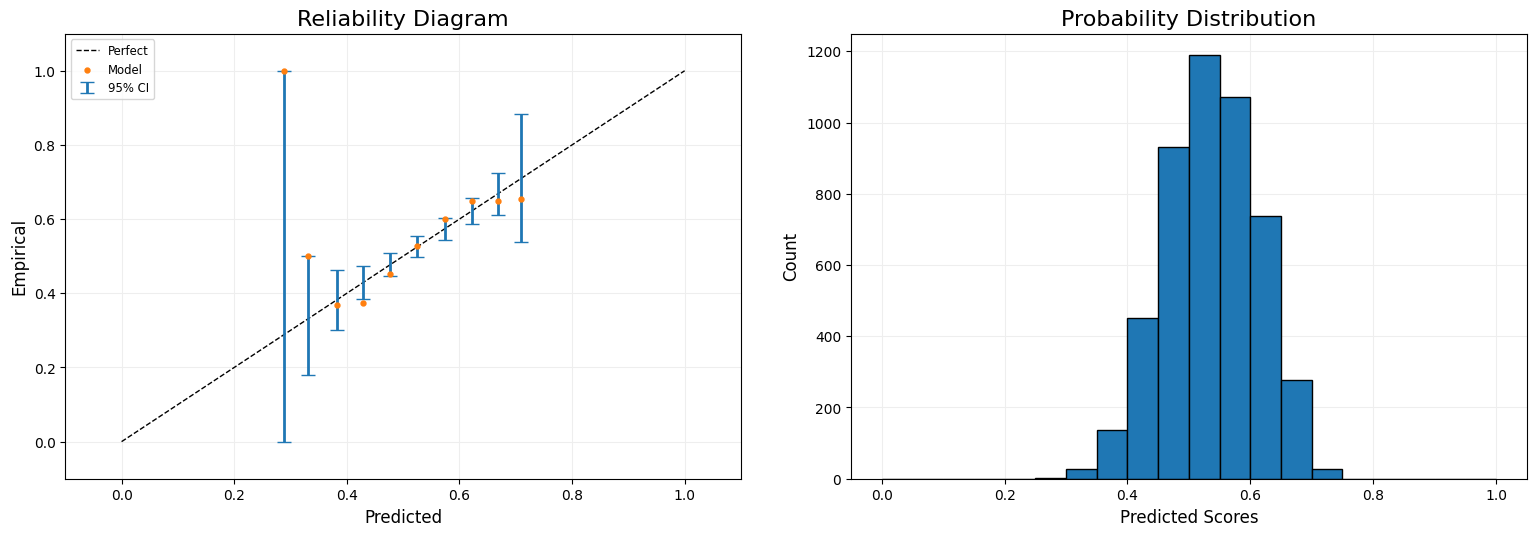

In [56]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [57]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.157084
Strt_SO_perc_10_v       0.084099
Strt_SO_perc_10_h       0.078503
Strt_WHIP_35_v          0.077702
OBP_162_v               0.068343
Strt_WHIP_35_h          0.066323
OBP_162_h               0.060820
SLG_162_h               0.043052
Strt_TB_BB_perc_35_h    0.040666
SLG_162_v               0.035917
Strt_TB_BB_perc_35_v    0.031168
dtype: float64

# How much do these differences in log loss really mean?
- When model A does a few bps better than model B in log loss, how should we think about that?

- Is it a meaningful improvement?
- How do we know it is not just "luck of the draw" of the test set
- 
We'll run some quick simulations to build our intuition about this.

In [58]:
# Simulate a test set (with given "true" probabilities) and compare two models, 
def ll_dist(probvec_true, probvec_mod1, probvec_mod2, num_trials):
    llvec_mod1 = np.zeros(num_trials)
    llvec_mod2 = np.zeros(num_trials)
    for i in range(num_trials):
        sim_outcome = np.random.binomial(n=1, p=probvec_true)
        llvec_mod1[i] = log_loss(sim_outcome, probvec_mod1)
        llvec_mod2[i] = log_loss(sim_outcome, probvec_mod2)
    return(llvec_mod1 - llvec_mod2)

In [59]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

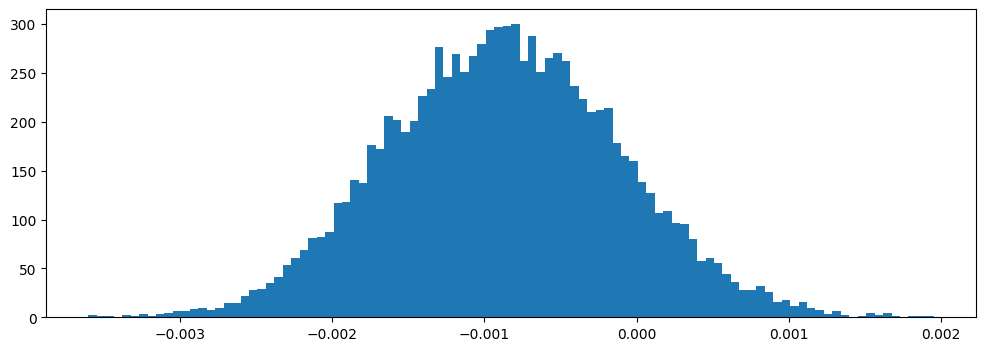

In [60]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

In [61]:
pv_true = np.repeat(df_test.implied_prob_h_mid,10)
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

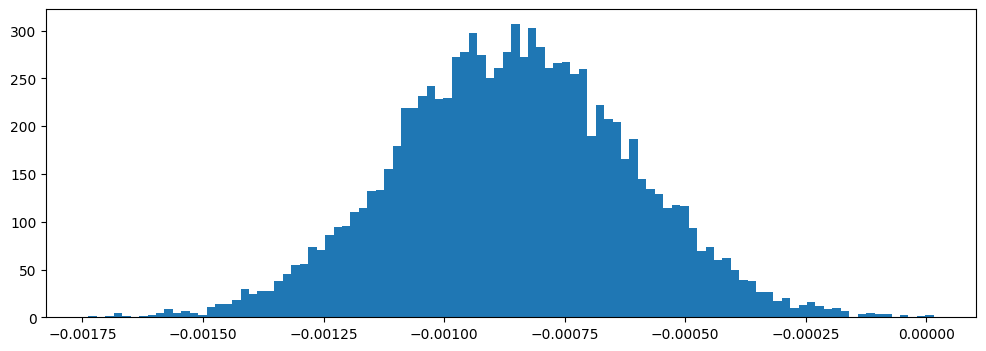

In [62]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

In [63]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.10, .10, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

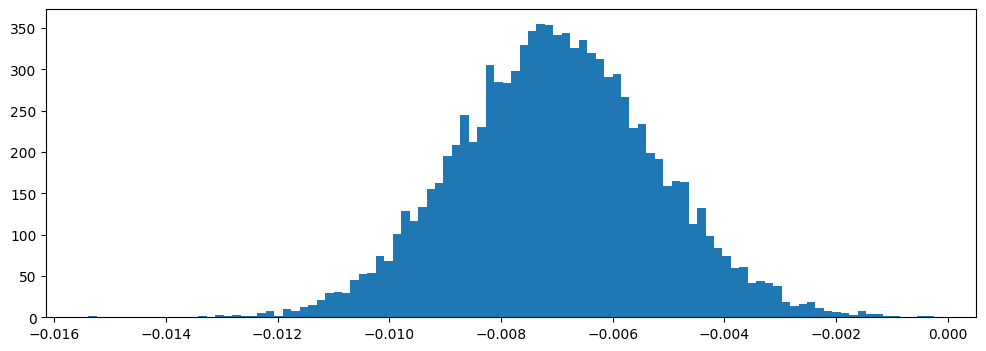

In [64]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

# Conclusions
- Could be that 5-10 bps improvement is meaningful!
- Variation due to test set size is considerable
- Not a simple matter to increase test set size in this problem
- For now, still need to improve beyond minor optimizations

# Next Steps

- Bullpen could have a positive impact on our model
- Model drift could affect how project progresses
- Account for hitting lineup
- Account for fielding
- Other additons
  - Rule changes
  - Pitch clock
  - NL has DH now